# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести.**

Смена рабочей директории.

In [2]:
import os
os.chdir(r'D:\Study\Magistracy\2025\3\ForProject\2025_Markov_TimeSeriesCourse-main\practice\01 Basics')

Использование команд, которые автоматически перезагружают все импортированные модули при их изменении.

In [1]:
%load_ext autoreload
%autoreload 2

## **Часть 1.** Евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация.

Импорт библиотек и модулей.

In [3]:
import numpy as np
import pandas as pd

from modules.metrics import *
from modules.utils import *
from modules.plots import *

### **Задача 1.**
Вам необходимо самостоятельно реализовать функцию `ED_distance()` в модуле *metrics.py* для нахождения евклидовой метрики между временными рядами, имеющими одинаковую длину, и проверить ее реализацию с помощью функции `euclidean_distance()` из библиотеки *sktime*. В качестве входных данных используйте два синтетических временных ряда некоторой заданной вами длины, сгенерированных моделью случайных блужданий (Random Walk). Модель случайных блужданий реализуйте самостоятельно или используйте готовые реализации.

*Евклидова метрика* между временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

In [4]:
%pip install sktime

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\marko\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
from sktime.distances import euclidean_distance
import random

def test_ed_distance(ts1, ts2):

    sktime_ed_dist = round(euclidean_distance(ts1, ts2), 5)
    desired_ed_dist = round(ED_distance(ts1, ts2), 5)

    np.testing.assert_equal(sktime_ed_dist, desired_ed_dist, 'ED distances are not equal')

In [6]:
length = 5
test_ed_distance(random_walk(length), random_walk(length))

### **Задача 2.**

Вам необходимо самостоятельно реализовать функцию `DTW_distance()` в модуле *metrics.py* для нахождения DTW меры между временными рядами, имеющими одинаковую длину, и проверить ее реализацию с помощью функции `dtw_distance()` из библиотеки *sktime*. Сгенерируйте два временных ряда некоторой заданной вами длины с помощью модели случайных блужданий (Random Walk) или используйте ряды из предыдущей задачи.

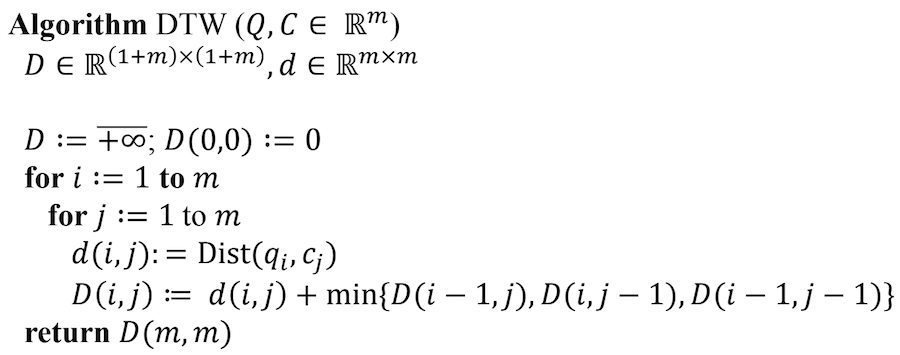

In [7]:
import random
from sktime.distances import dtw_distance

def test_dtw_distance(ts1, ts2):

    sktime_dtw_dist = dtw_distance(ts1, ts2)
    desired_dtw_dist = DTW_distance(ts1, ts2)

    np.testing.assert_equal(sktime_dtw_dist, desired_dtw_dist, 'DTW distances are not equal')

In [8]:
length = 5
test_dtw_distance(random_walk(length), random_walk(length))

### **Задача 3.**
Реализуйте функцию нахождения матрицы расстояния между временными рядами. Для вычисления расстояний между рядами используйте реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(A,B)=dist(B,A)$), то матрица расстояний будет квадратной и симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом: $dist\_matrix(j,i) = dist\_matrix(i,j)$, где $i < j$.

In [9]:
def calculate_distance_matrix(data, metric='euclidean', normalize=True):
    
    if metric=='euclidean':
        dist_func = ED_distance
    elif metric=='dtw':
        dist_func = DTW_distance
    else:
        raise ValueError("Metric must be 'euclidean' or 'dtw'.")

    N = data.shape[0] # number of time series

    # Initialize the distance matrix
    distance_matrix = np.zeros(shape=(N, N))
    
    for i in range(N):
        for j in range(i, N):
            if i == j:
                distance_matrix[i, j] = 0.0
            else:
                distance_matrix[i, j] = dist_func(data[i], data[j])
    
    distance_matrix = distance_matrix + distance_matrix.T

    return distance_matrix

### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться вычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла CBF_TRAIN.txt. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2), которая записана в первом столбце, и временной ряд -- в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [10]:
def load_ts(file_name):

    ts = pd.read_csv(file_name, header=None, delim_whitespace=True)

    return ts

In [11]:
url = r'D:\Study\Magistracy\2025\3\ForProject\2025_Markov_TimeSeriesCourse-main\practice\01 Basics\datasets\part1\CBF_TRAIN.txt'

data = load_ts(url)

ts_set = data.iloc[:, 1:].to_numpy()
labels = data.iloc[:, 0].squeeze().to_numpy()

C:\Users\marko\AppData\Local\Temp\ipykernel_17476\3852541726.py:3: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Выполните визуализацию экземпляра каждого класса. Для этого используйте функцию `plot_ts_set()` из модуля *plots.py*.

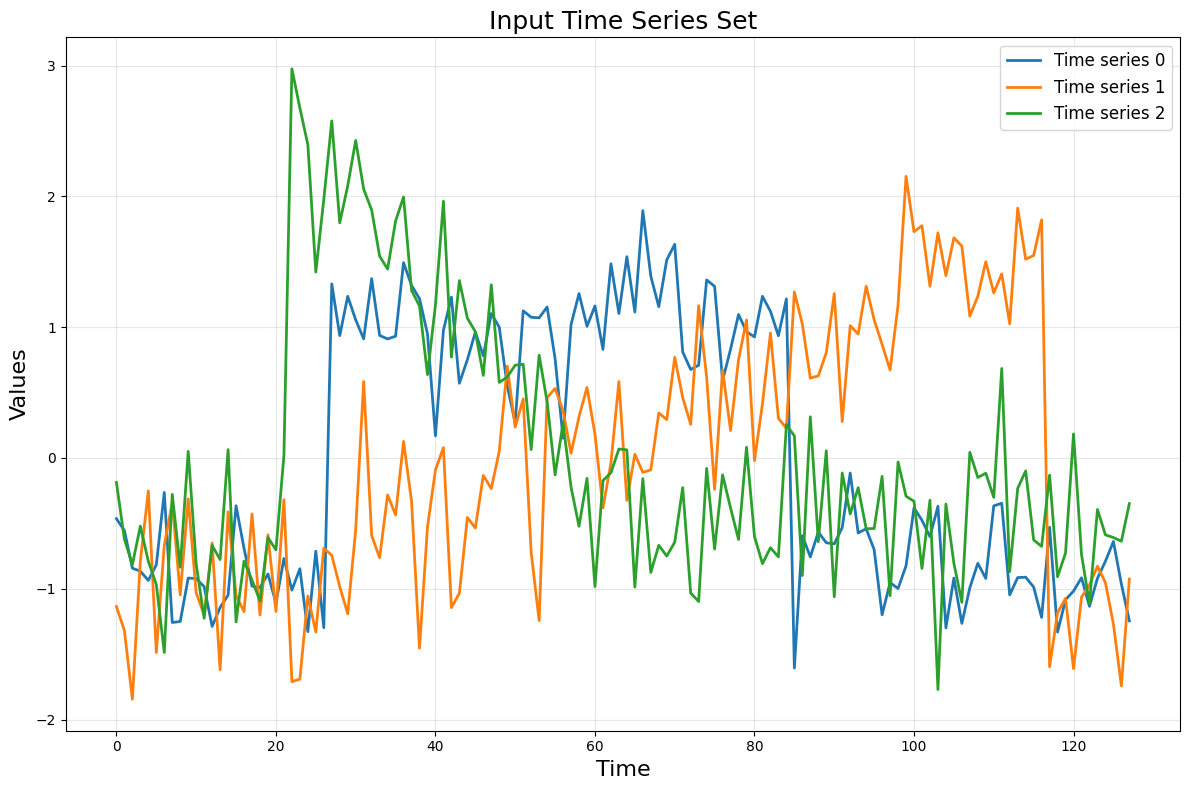

In [12]:
idxs = [list(labels).index(1), list(labels).index(2), list(labels).index(3)]
plot_ts_set(pd.DataFrame(ts_set).iloc[idxs].to_numpy())

Далее вам необходимо самостоятельно реализовать класс для выполнения иерархической кластеризации временных рядов.

Перед тем как приступить к его реализации, изучите скелет класса `TimeSeriesHierarchicalClustering`, который представлен в модуле *clustering.py*. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию AgglomerativeClustering из *sklearn*.   

Протестируйте свою реализацию иерархической кластеризации на наборе данных CBF для двух метрик: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами и передайте их в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

In [13]:
from modules.clustering import *

#### euclidean

In [14]:
dist_marix = calculate_distance_matrix(ts_set, metric='euclidean')
model = TimeSeriesHierarchicalClustering(n_clusters=3).fit(dist_marix)

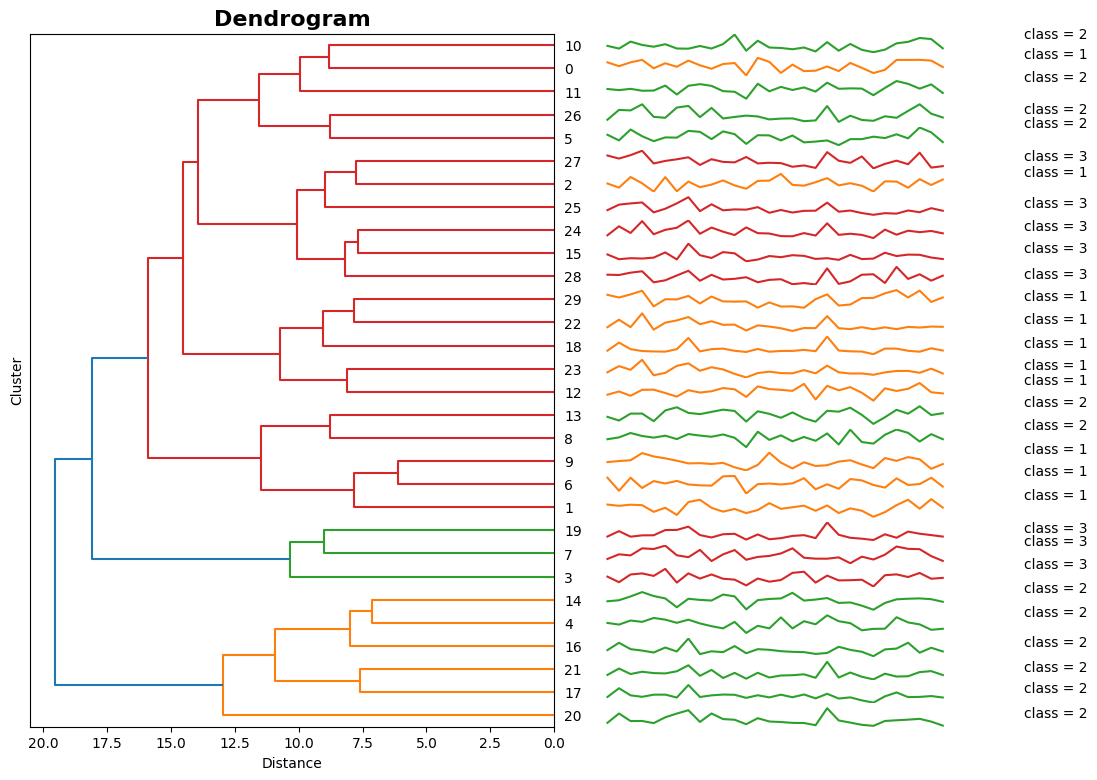

In [15]:
model.plot_dendrogram(pd.DataFrame(ts_set), labels)

#### dtw

In [16]:
dist_marix = calculate_distance_matrix(ts_set, metric='dtw')
model = TimeSeriesHierarchicalClustering(n_clusters=3).fit(dist_marix)

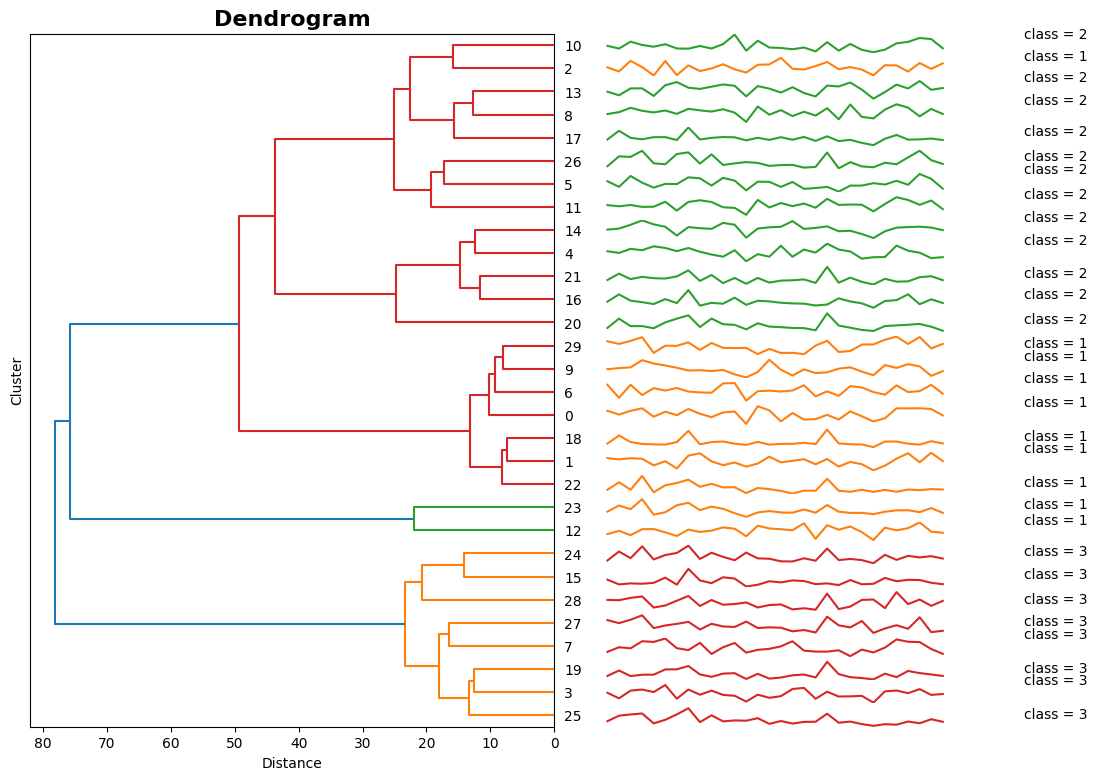

In [17]:
model.plot_dendrogram(pd.DataFrame(ts_set), labels)

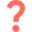
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм. Какая на ваш взгляд метрика/мера показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать меру DTW, чем метрику Евклида.

**Евклидово расстояние интуитивно понятно и у этой метрики ниже вычислительная сложность, однако работает только для рядов одинаковой длины и не учитывает форму рядов. DTW, напротив, учитывает форму рядов, а также может работать с рядами разной длины, но вычислительно сложнее.**

## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации с помощью функции `ed_distance()` из библиотеки *sktime*, в которую необходимо передать нормализованные временные ряды. Для  нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать моделью Random Walk.

*Нормализованная евклидова метрика* между временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}\;(T_1, T_2) = \sqrt {2m\left(1-\dfrac{<T_1, T_2> - \; m \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{m \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)},
\end{equation}

где $<T_1, T_2>$ -- скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ -- среднее арифметическое и стандартное отклонение временных рядов соответственно.

В свою очередь, *среднее арифметическое* $\mu_T$ и *стандартное отклонение* $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma^2_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [18]:
def test_norm_ed_distance(ts1, ts2):

    sktime_ed_dist = round(euclidean_distance(z_normalize(ts1), z_normalize(ts2)), 5)
    desired_ed_dist = round(norm_ED_distance(ts1, ts2), 5)

    np.testing.assert_equal(sktime_ed_dist, desired_ed_dist, 'Normalized ED distances are not equal')

In [19]:
length = 5
test_norm_ed_distance(random_walk(length), random_walk(length))

### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных вам предлагается использовать два временных ряда из набора данных BIDMC. Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts_set()` из модуля *plots.py*.

In [20]:
url1 = r'D:\Study\Magistracy\2025\3\ForProject\2025_Markov_TimeSeriesCourse-main\practice\01 Basics\datasets\part2\chf10.csv'
ts1 = load_ts(url1)

url2 = r'D:\Study\Magistracy\2025\3\ForProject\2025_Markov_TimeSeriesCourse-main\practice\01 Basics\datasets\part2\chf11.csv'
ts2 = load_ts(url2)

C:\Users\marko\AppData\Local\Temp\ipykernel_17476\3852541726.py:3: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

C:\Users\marko\AppData\Local\Temp\ipykernel_17476\3852541726.py:3: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [21]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

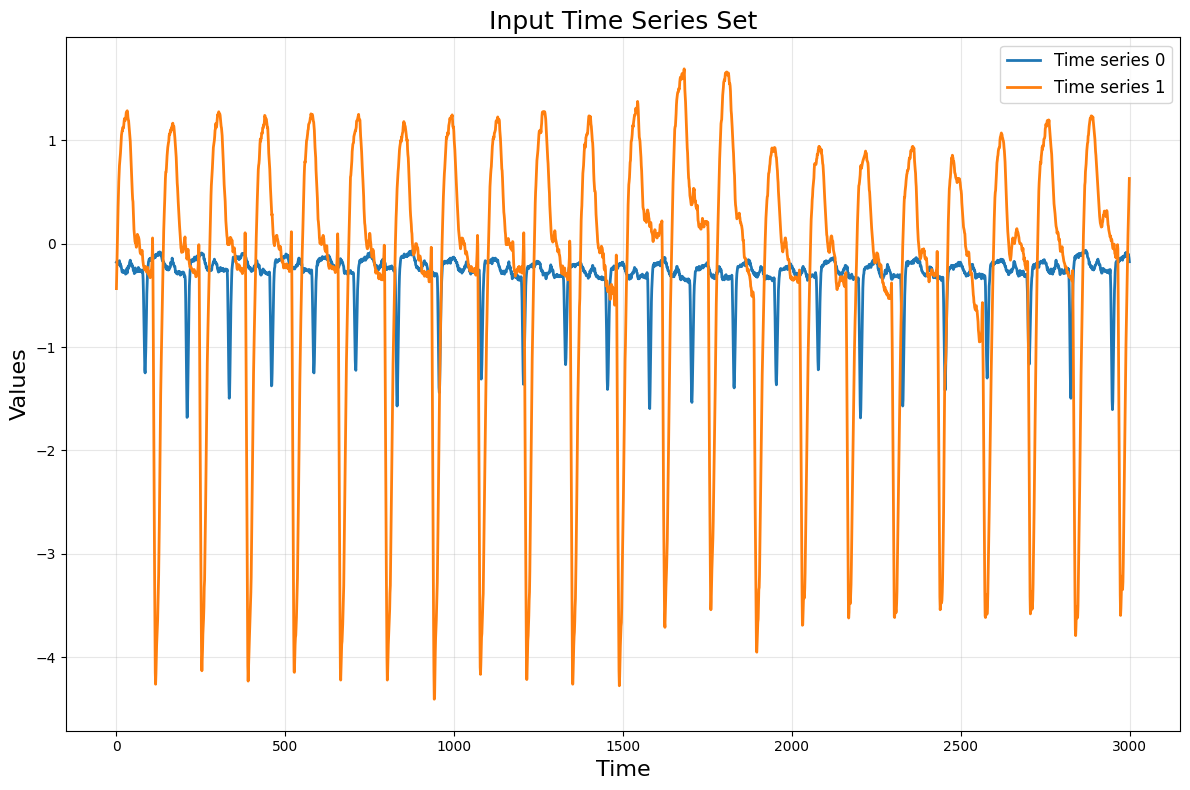

In [22]:
plot_ts_set(ts_set)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [23]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [24]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в функцию `calculate_distance_matrix()` поддержку параметра `normalize`, принимающего значения `True` или `False`, для возможности кластеризации нормализованных временных рядов. При этом если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

In [30]:
def calculate_distance_matrix(data, metric='euclidean', normalize=True):

    N = data.shape[0] # number of time series
    
    if metric=='euclidean':
        if normalize:
            dist_func = norm_ED_distance
        else:
            dist_func = ED_distance
    elif metric=='dtw':
        if normalize:
            for i in range(N):
                data[i] = z_normalize(data[i])
        dist_func = DTW_distance
    else:
        raise ValueError("Metric must be 'euclidean' or 'dtw'.")

    # Initialize the distance matrix
    distance_matrix = np.zeros(shape=(N, N))
    
    for i in range(N):
        for j in range(i, N):
            if i == j:
                distance_matrix[i, j] = 0.0
            else:
                distance_matrix[i, j] = dist_func(data[i], data[j])
    
    distance_matrix = distance_matrix + distance_matrix.T

    return distance_matrix

#### classical

In [31]:
dist_marix = calculate_distance_matrix(subs_set, metric='euclidean', normalize=False)
model = TimeSeriesHierarchicalClustering(n_clusters=2).fit(dist_marix)

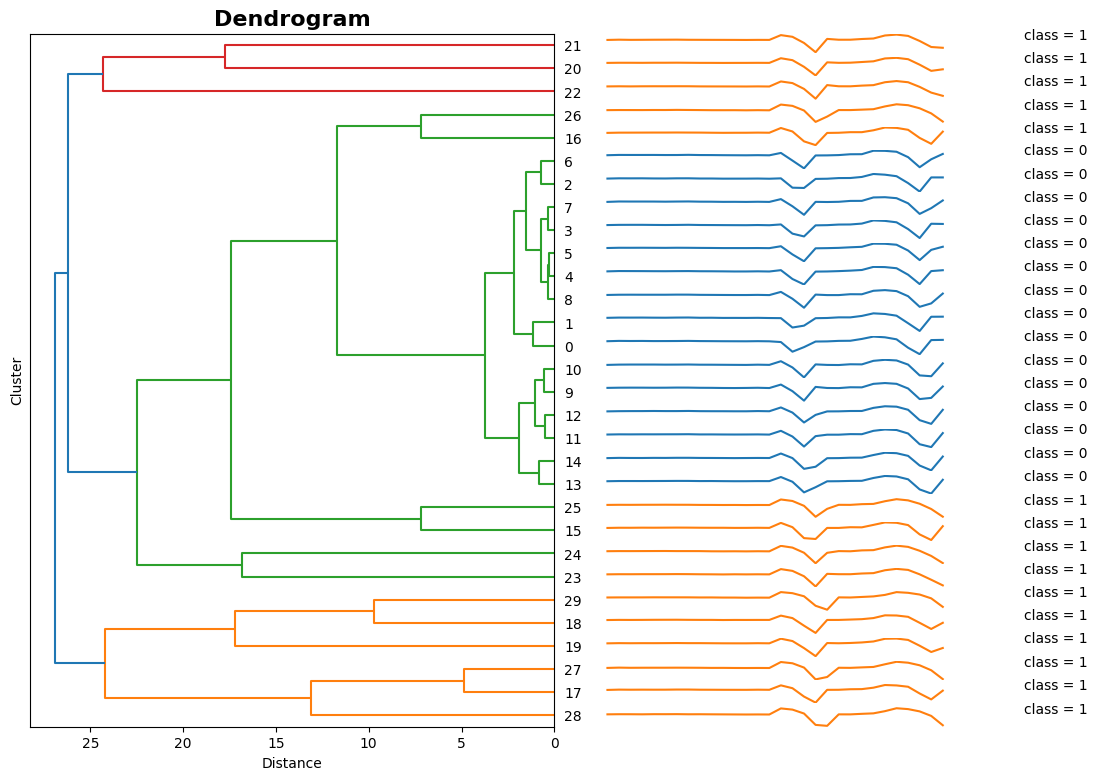

In [32]:
model.plot_dendrogram(pd.DataFrame(subs_set), labels)

#### normalized

In [33]:
dist_marix = calculate_distance_matrix(subs_set, metric='euclidean')
model = TimeSeriesHierarchicalClustering(n_clusters=2).fit(dist_marix)

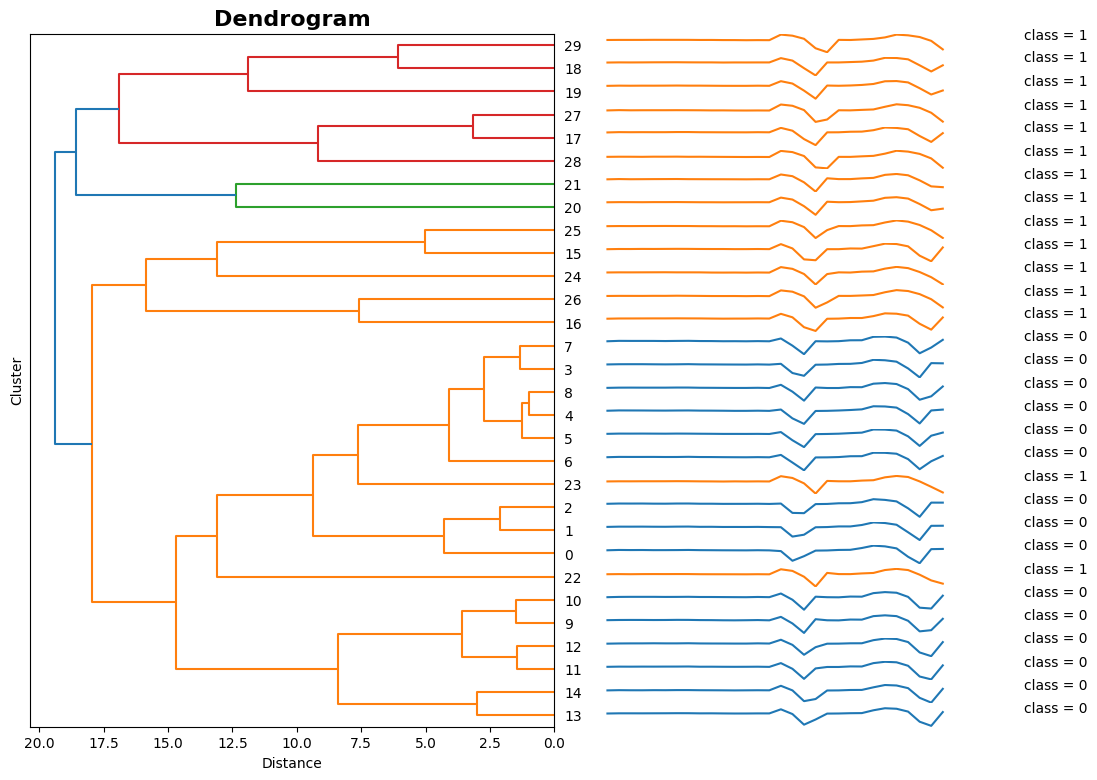

In [34]:
model.plot_dendrogram(pd.DataFrame(subs_set), labels)

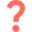
Сравните полученные результаты кластеризации с помощью построенных дендрограмм. Улучшилось ли качество кластеризации, когда временные ряды предварительно подтвергаются $z$-нормализации?

**Качество кластеризации улучшилось после 𝑧-нормализации. До нормализации кластеризация долго не могла различить почти половину данных.**